# Tabla de contenido

1. Descripción de proyecto
2. Objetivo del proyecto
3. Inicialización
4. Carga de datos
5. Procesamiento de datos 
    
    5.1 Valores nulos
    
    5.2 Valores duplicados
    
    
6. Análisis exploratorio
7. Estadisticas para los operadores
    
    7.1 Distribución de llamadas entrantes pérdidas
    
    7.2 Distribución de tiempo promedio de espera de llamadas
    
    7.3 Distribución de llamadas salientes
    
    
8. Operaciones ineficientes
9. Hipótesis
10. Conclusión
11. Recomendación
12. Acciones futuras
13. Links

## Descripción de proyeto

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

## Objetivos del proyecto

- **¿Qué queremos conseguir y por qué?** Obtener información de los operadores menos eficaces.
    
- **¿A quién le interesa el producto?** A los supervisores y las supervisores.

- **¿Qué decisiones se tomarán de acuerdo al análisis?**

**Criterios de Ineficacia del Operador:**
Un operador se considerará ineficaz si cumple con las siguientes condiciones:

**Llamadas Entrantes Perdidas:** El operador tiene un alto número de llamadas perdidas tanto internas como externas.
Tiempo de Espera Prolongado: Las llamadas entrantes experimentan largos tiempos de espera antes de ser atendidas por el operador.

**Llamadas Salientes Insuficientes:** Si se espera que el operador realice llamadas salientes, pero su número es significativamente menor de lo esperado, esto también será indicativo de ineficacia.

## Inicialización

In [237]:
# Cargar todas las librerías
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Cargar los datos

In [238]:
# cargar información de los operadores
telecom_dataset_us = pd.read_csv('/datasets/telecom_dataset_us.csv',parse_dates=['date'])

In [239]:
# cargar información de los clientes
telecom_clients_us = pd.read_csv('/datasets/telecom_clients_us.csv',parse_dates=['date_start'])

In [240]:
# mostramos información general del set de datos de los operadores
telecom_dataset_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53902 non-null  int64                                
 1   date                 53902 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53902 non-null  object                               
 3   internal             53785 non-null  object                               
 4   operator_id          45730 non-null  float64                              
 5   is_missed_call       53902 non-null  bool                                 
 6   calls_count          53902 non-null  int64                                
 7   call_duration        53902 non-null  int64                                
 8   total_call_duration  53902 non-null  int64                                
dtypes: bool

In [241]:
# mostramos parte de los datos de los operadores
telecom_dataset_us.sample(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
10289,166678,2019-09-10 00:00:00+03:00,in,False,900892.0,False,3,412,424
21217,167016,2019-11-26 00:00:00+03:00,out,True,962902.0,False,3,181,237
16962,166916,2019-11-12 00:00:00+03:00,out,True,906416.0,True,1,0,43
606,166392,2019-08-29 00:00:00+03:00,in,False,891900.0,False,1,4,46
19702,166985,2019-11-05 00:00:00+03:00,in,False,NaN,True,1,0,16


---
El dataset comprimido `telecom_dataset_us.csv` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada en minutos (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada en minutos (incluido el tiempo de espera)


**Tenemos 53,902 registros y nueve columnas.** El tipo de datos para cada columna es el correcto, a excepción de la columna `'operator_id'` que tiene el tipo `'float64'` pero observando sus valores podemos convertirlo al tipo `'int64'`.


In [242]:
# mostramos información general del set de datos de los clientes
telecom_clients_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


In [243]:
# mostramos parte de los datos de los clientes
telecom_clients_us.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


---
El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela


**Tenemos 732 registros y tres columnas.** 


## Preprocesamiento de datos  

### Valores nulos

In [244]:
# revisamos el dataset de los operadores
telecom_dataset_us.isna().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [245]:
# revisamos el dataset de los usuarios
telecom_clients_us.isna().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

In [246]:
# revisamos el dataset para los valores nulos en la columna 'internal'
# 'internal' nos dice si la llamada fue hecha entre los operadores de un cliente, toma valores 'True' o 'False'
telecom_dataset_us[telecom_dataset_us['internal'].isna()].sample(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
39519,167747,2019-10-18 00:00:00+03:00,in,NaN,NaN,True,1,0,8
23183,167078,2019-11-13 00:00:00+03:00,in,NaN,935348.0,False,2,73,84
36251,167599,2019-11-03 00:00:00+03:00,in,NaN,NaN,True,1,0,2
21004,167016,2019-10-23 00:00:00+03:00,out,NaN,NaN,True,3,0,196
41111,167828,2019-11-18 00:00:00+03:00,in,NaN,940430.0,False,1,363,364
52187,168361,2019-11-01 00:00:00+03:00,in,NaN,NaN,True,3,0,15
24505,167110,2019-10-16 00:00:00+03:00,in,NaN,NaN,True,1,0,4
51505,168307,2019-11-01 00:00:00+03:00,in,NaN,945046.0,False,1,745,748
24489,167110,2019-09-19 00:00:00+03:00,in,NaN,NaN,True,1,0,5
43466,167998,2019-10-23 00:00:00+03:00,in,NaN,NaN,True,1,0,2


In [247]:
# veamos la distribución de los valores en la columna 'internal'
telecom_dataset_us['internal'].value_counts(dropna=False)

False    47621
True      6164
NaN        117
Name: internal, dtype: int64

Podemos ver que es más probable el valor `'False'` por lo que estimaremos los valores nulos usando el valor `'False'`.

In [248]:
# reemplazamos los valores nulos en la columna 'internal'
telecom_dataset_us['internal'].fillna(False,inplace=True)

In [249]:
# verificamos que se haya hecho el reemplazo
telecom_dataset_us.isna().sum()

user_id                   0
date                      0
direction                 0
internal                  0
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

Ya no tenemos valores nulos en la columna `'internal'`, procedemos ahora a revisar la columna `'operador_id'`.

In [250]:
# Agrupar por 'user_id', 'direction' y contar las frecuencias de 'operator_id'
result = telecom_dataset_us.groupby(['user_id', 'direction', 'operator_id']).size().reset_index(name='frequency')

# Mostrar las últimas 10 filas del resultado
print(result.tail(10))

      user_id direction  operator_id  frequency
1626   168583        in     952126.0          5
1627   168583        in     962062.0         12
1628   168598        in     958394.0         11
1629   168601        in     952914.0         18
1630   168601        in     952916.0          1
1631   168601       out     952914.0         37
1632   168601       out     952916.0          4
1633   168603       out     959118.0          7
1634   168606        in     957922.0          2
1635   168606       out     957922.0          8


Notamos que no hay manera de imputar adecuadamente los valores nulos de `'operator_id'`, de tal forma que para no incurrir en errores en el cálculo de alguna estadística vamos a proceder a eliminar esos registros con valores nulos y ver la cantidad de información que perdemos.

In [251]:
# creamos un dataframe sin valores nulos
telecom_dataset_us_notna=telecom_dataset_us[telecom_dataset_us['operator_id'].notna()]
telecom_dataset_us_notna.shape

(45730, 9)

In [252]:
# revisamos el dataframe creado en busca de valores nulos
telecom_dataset_us_notna.isna().sum()

user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
dtype: int64

Podemos notar que en el dataframe `'telecom_dataset_us_notna'` ya no tenemos valores nulos y que contamos con 45,730 registros y nueve columnas. Además, al eliminar esos 8,172 valores nulos hemos perdido aproximadamente un $\frac{8172}{53902} x 100=15.16\% $ de la información.

In [253]:
telecom_dataset_us_notna = telecom_dataset_us_notna.copy()
telecom_dataset_us_notna['operator_id'] = telecom_dataset_us_notna['operator_id'].astype('int64')

In [254]:
# finalmente transformemos el tipo de datos de la columna 'operator_id' a una de tipo 'int64'
telecom_dataset_us_notna.loc[:, 'operator_id'] = telecom_dataset_us_notna['operator_id'].astype('int64')

In [255]:
# obtengamos el tiempo de espera de la llamada
telecom_dataset_us_notna.loc[:,'time_waiting']=telecom_dataset_us_notna.loc[:,'total_call_duration']-telecom_dataset_us_notna.loc[:,'call_duration']

In [256]:
# mostramos la información general del dataframe
telecom_dataset_us_notna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45730 entries, 1 to 53900
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              45730 non-null  int64                                
 1   date                 45730 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            45730 non-null  object                               
 3   internal             45730 non-null  bool                                 
 4   operator_id          45730 non-null  int64                                
 5   is_missed_call       45730 non-null  bool                                 
 6   calls_count          45730 non-null  int64                                
 7   call_duration        45730 non-null  int64                                
 8   total_call_duration  45730 non-null  int64                                
 9   time_w

### Valores duplicados

In [257]:
# buscamos valores nulos en los registros de los usuarios
telecom_clients_us.duplicated().sum()

0

In [258]:
# buscamos valores nulos en los registros de los operadores
telecom_dataset_us_notna.duplicated().sum()

4184

In [259]:
# eliminamos los registros duplicados en el dataframe de los operadores sin valores nulos
telecom_dataset_us_notna.drop_duplicates(inplace=True)

In [260]:
# verificamos que se hayan eliminado los duplicados
telecom_dataset_us_notna.duplicated().sum()

0

In [261]:
# veamos el tamaño total del último dataframe creado para realizar los análisis
telecom_dataset_us_notna.shape

(41546, 10)

Este último dataframe ya no contiene valores nulos ni duplicados y cada columna tiene el tipo de datos correcto. Podemos ahora proceder a realizar un análisis exploratorio. Hemos perdido en total $\frac{12356}{53902} x 100=22.9\% $ de la información.

## Análisis exploratorio 

In [262]:
# creamos una lista con las variables a observar su distribución
variables=['calls_count','call_duration','total_call_duration','time_waiting']

In [263]:
# veamos información general de las variables 'calls_count','call_duration' y 'total_call_duration'
telecom_dataset_us_notna[variables].describe().T

,count,mean,std,min,25%,50%,75%,max
calls_count,41546.0,16.900424,59.749373,1.0,1.0,4.0,13.0,4817.0
call_duration,41546.0,1009.769172,4064.106117,0.0,0.0,106.0,770.0,144395.0
total_call_duration,41546.0,1321.592813,4785.978633,0.0,67.0,288.0,1104.0,166155.0
time_waiting,41546.0,311.823641,1175.373073,0.0,19.0,60.0,219.0,46474.0



La gran disparidad entre las medias y las medianas sugiere la presencia de valores atípicos en las variables, lo que a su vez indica que la distribución de los datos es asimétrica hacia la derecha. Esto significa que hay valores extremadamente altos que están estirando la distribución hacia la derecha, haciendo que la media sea mayor que la mediana y provocando que la gráfica tenga una cola más larga en ese lado, mientras que la parte central se inclina hacia la izquierda.

Limite-inferior: -17.00     Limite-superior: 31.00


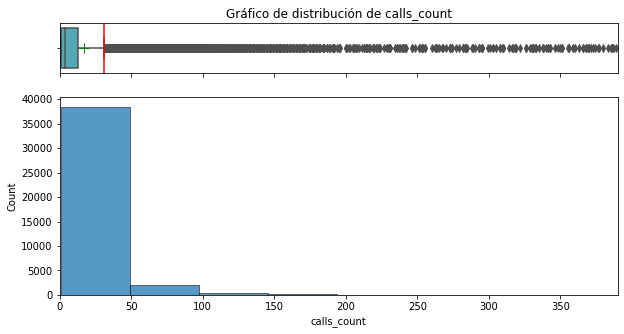

Limite-inferior: -1155.00     Limite-superior: 1925.00


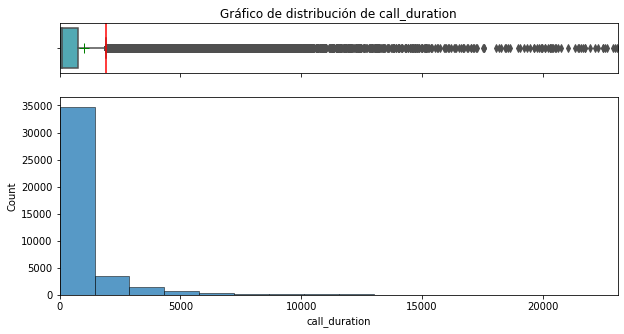

Limite-inferior: -1488.50     Limite-superior: 2659.50


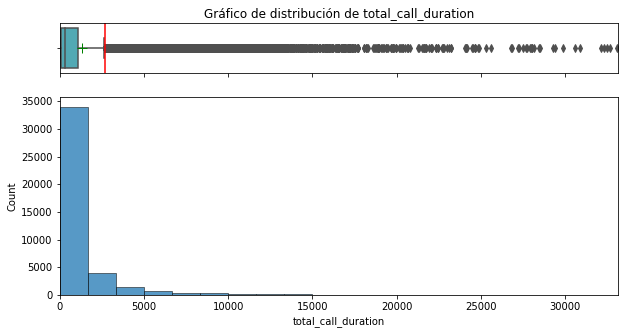

Limite-inferior: -281.00     Limite-superior: 519.00


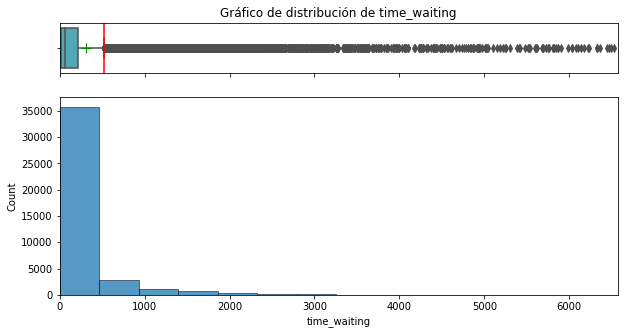

In [264]:
# creamos los gráficos 'boxplot' que incluyen los valores teóricos de los bigotes
for var in variables:
    Q1 = telecom_dataset_us_notna[var].quantile(0.25)
    Q3 = telecom_dataset_us_notna[var].quantile(0.75)
    
    # rango intercuantílico
    IQR=Q3-Q1
    # bigote superior Q3+1.5*IQR
    # bigote inferior Q1-1.5*IQR
    titulo=str(var)
    print(f'Limite-inferior: {Q1-1.5*IQR:.2f}     Limite-superior: {Q3+1.5*IQR:.2f}')  
    fig, ax = plt.subplots(2,sharex=True,
                     gridspec_kw={"height_ratios": (.20, .80)},figsize=(10,5))
    
    # gráfico boxplot
    sns.boxplot(x=var,data=telecom_dataset_us_notna,ax=ax[0],palette='YlGnBu_r',\
                   showmeans=True,meanprops={"marker": "+","markeredgecolor": "green","markersize": "10"})
    ax[0].axvline(x=Q1-1.5*IQR,color='red')
    ax[0].axvline(x=Q3+1.5*IQR,color='red')
    ax[0].set(xlabel=None)
    ax[0].set(title='Gráfico de distribución de '+titulo)
    
    # gráfico de distribución
    sns.histplot(telecom_dataset_us_notna[var],bins=100,ax=ax[1])
    plt.xlim(0,30*Q3)
    #plt.title('Valores teóricos de los limites de '+titulo)
    plt.show()

De los gráficos anteriores podemos notar que las variables `'calls_count'`, `'call_duration'`, `'total_call_duration'` y `'time_waiting'` presentan distribuciones con asimetría positiva y muchos valores outliers.

In [265]:
# veamos ahora el comportamiento de las variables 'direction', 'internal' y 'is_missed_call'
categoricas=['direction','internal','is_missed_call']

In [266]:
def plot_categorical(data, variable):
    """
    data: DataFrame que contiene registros de usuarios.
    variable: Variable categórica de la que se desean obtener las frecuencias.
    """
    # Agrupamos y obtenemos las frecuencias
    grouped = data[variable].value_counts(normalize=True).reset_index()
    grouped.columns = ['Categoría', 'Frecuencia']

    # Creamos el gráfico de barras
    plt.figure(figsize=(4, 4))
    sns.barplot(data=grouped, x='Categoría', y='Frecuencia')

    # Etiquetar las barras
    for rect in plt.gca().patches:
        x_value = rect.get_x() + rect.get_width() / 2
        y_value = rect.get_height()
        space = 3
        label = "{:.1%}".format(y_value)
        plt.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom', rotation=45)

    plt.ylim(0, grouped['Frecuencia'].max() * 1.3)
    plt.title('Gráfico de ' + variable)
    plt.show()

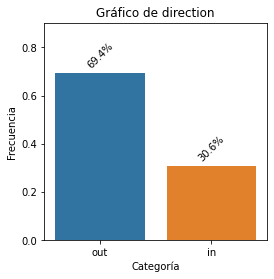

In [267]:
# creamos la gráfica para 'direction'
plot_categorical(data=telecom_dataset_us_notna,variable='direction')

Tenemos que un 69.4% de las llamadas son salientes y solo un 30.6% son entrantes.

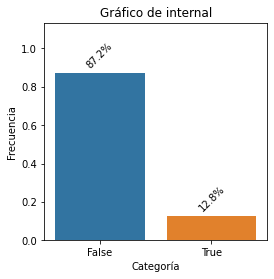

In [268]:
# creamos la gráfica para 'internal'
plot_categorical(data=telecom_dataset_us_notna,variable='internal')

Solo 12.8% de las llamadas son realizadas entre los operadores.

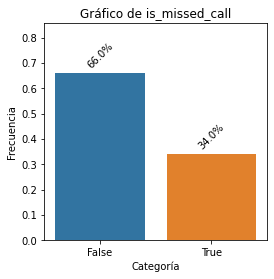

In [269]:
# creamos la gráfica para 'is_missed_call'
plot_categorical(data=telecom_dataset_us_notna,variable='is_missed_call')

El 34% de las llamadas son llamadas perdidas.

## Estadísticas para los operadores 

In [270]:
# Agrupamos todas las llamadas por operador
calls_by_operator = telecom_dataset_us_notna.groupby(['operator_id', 'direction']).agg({
    'calls_count': 'sum',
    'call_duration': 'sum',
    'is_missed_call': 'sum',
    'time_waiting': 'sum'
}).sort_values(['is_missed_call', 'time_waiting'], ascending=False).reset_index()

# Calculamos la duración promedio por llamada
calls_by_operator['mean_duration'] = calls_by_operator['call_duration'] / calls_by_operator['calls_count']

# Calculamos el tiempo promedio de espera por llamada
calls_by_operator['mean_waiting'] = calls_by_operator['time_waiting'] / calls_by_operator['calls_count']

# Mostramos una muestra aleatoria de 5 filas
calls_by_operator.sample(5)

,operator_id,direction,calls_count,call_duration,is_missed_call,time_waiting,mean_duration,mean_waiting
432,944648,out,41,2388,10,432,58.243902,10.536585
211,890618,out,270,17167,22,5791,63.581481,21.448148
887,960620,in,50,4534,1,748,90.680000,14.960000
242,939684,out,131,7367,20,1669,56.236641,12.740458
676,887992,out,47,971,3,680,20.659574,14.468085


### Distribución de las llamadas entrantes pérdidas

In [271]:
# obtengamos información general del set de datos de las llamadas entrantes pérdidas
calls_in_missed_operator=calls_by_operator.query('direction=="in"')
calls_in_missed_operator.describe()

,operator_id,calls_count,call_duration,is_missed_call,time_waiting,mean_duration,mean_waiting
count,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000
mean,923704.400531,124.405836,12631.314324,0.908488,1635.656499,102.161798,17.491612
std,22646.733795,356.450649,34048.272424,2.405363,4637.607919,103.592874,12.171988
min,879896.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.683673
25%,905153.000000,4.000000,226.250000,0.000000,62.000000,50.153237,9.398782
50%,924580.000000,17.000000,1480.500000,0.000000,255.000000,86.291667,14.430502
75%,940457.500000,78.750000,8097.750000,1.000000,1064.250000,126.035088,21.838889
max,973286.000000,4766.000000,397079.000000,28.000000,52875.000000,1799.000000,115.500000


In [272]:
# obtenemos percentiles para la cantidad de llamadas entrantes pérdidas
np.percentile(calls_in_missed_operator['is_missed_call'],[90,95,96,99])

array([ 2.  ,  4.35,  5.  , 11.47])

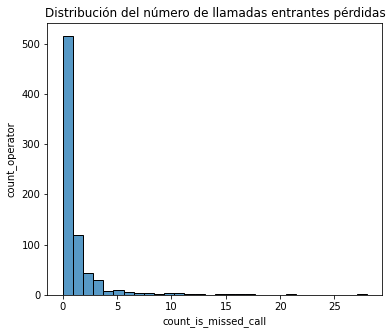

In [273]:
# veamos la distribución de las llamadas entrantes pérdidas
fig,ax=plt.subplots(figsize=(6,5))
sns.histplot(calls_in_missed_operator['is_missed_call'],bins=30)
plt.xlabel('count_is_missed_call')
plt.ylabel('count_operator')
plt.title('Distribución del número de llamadas entrantes pérdidas')
plt.show()


Podemos notar que la mayoría de los operadores tienen pocas llamadas entrantes perdidas, mientras que solo un pequeño número de operadores experimenta un alto volumen de llamadas perdidas. Para definir cuándo considerar a un operador como ineficiente, proponemos establecer un umbral mínimo de seis llamadas entrantes perdidas. Es importante destacar que el 96% de los operadores tienen cinco o menos llamadas perdidas, lo que refleja una eficiencia en su desempeño.

### Distribución de tiempo promedio de espera de llamadas

In [274]:
# obtenemos percentiles para el tiempo promedio de espera para las llamadas entrantes
np.percentile(calls_in_missed_operator['mean_waiting'],[90,95,99])

array([33.87011583, 41.57923977, 55.38205128])

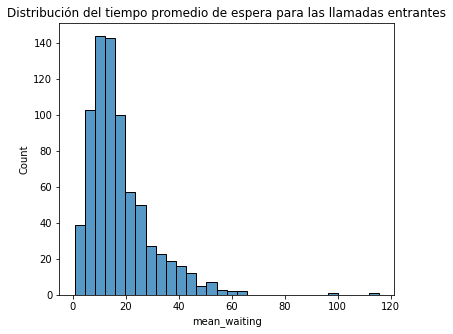

In [275]:
# veamos la distribución del tiempo promedio de espera para las llamadas entrantes
fig,ax=plt.subplots(figsize=(6,5))
sns.histplot(calls_in_missed_operator['mean_waiting'],bins=30)
plt.title('Distribución del tiempo promedio de espera para las llamadas entrantes')
plt.show()

Podemos observar que hay muy pocos operadores cuyo tiempo promedio de espera para las llamadas entrantes es mayor a 41.57. **Definamos a los operadores cuyo tiempo promedio de espera es mayor a 41.57 como un operador ineficiente.**

**Teniendo en cuenta las dos condiciones anteriores:**

1. Llamadas entrantes mayor a 6

2. Tiempo promedio de espera mayor a 41.57

Determinaremos a un operador como ineficiente.

### Distribución de las llamadas salientes

In [276]:
# obtengamos información general del set de datos de las llamadas salientes
calls_out_operator=calls_by_operator.query('direction=="out"')
calls_out_operator.describe()

,operator_id,calls_count,call_duration,is_missed_call,time_waiting,mean_duration,mean_waiting
count,882.000000,882.000000,8.820000e+02,882.000000,8.820000e+02,882.000000,882.000000
mean,925658.340136,689.731293,3.676628e+04,15.221088,1.328995e+04,61.727551,15.007958
std,22862.558731,3122.953946,1.890289e+05,18.549008,7.093113e+04,81.385731,6.755690
min,879896.000000,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,906394.500000,11.000000,3.470000e+02,2.000000,1.330000e+02,21.478459,10.253906
50%,924959.000000,90.000000,5.773500e+03,8.000000,1.314500e+03,45.719303,15.348039
75%,943630.000000,597.250000,3.134400e+04,21.000000,1.025650e+04,76.291820,19.245915
max,973120.000000,58977.000000,4.304731e+06,117.000000,1.431696e+06,1306.000000,60.000000


In [277]:
# obtenemos percentiles para la cantidad de llamadas salientes
np.percentile(calls_out_operator['calls_count'],[5,10,15,20,25])

array([ 1.,  3.,  5.,  8., 11.])

Límite inferior: -868.38   Límite superior: 1476.62


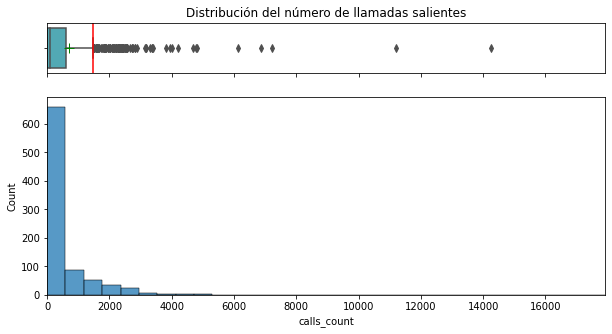

In [278]:
# Calculamos los cuartiles Q1 y Q3
Q1 = calls_out_operator['calls_count'].quantile(0.25)
Q3 = calls_out_operator['calls_count'].quantile(0.75)

# Calculamos el rango intercuartílico (IQR)
IQR = Q3 - Q1

# Definimos los límites para los bigotes del gráfico
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f'Límite inferior: {limite_inferior:.2f}   Límite superior: {limite_superior:.2f}')

# Creamos el gráfico de caja y bigotes
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)}, figsize=(10, 5))
sns.boxplot(x='calls_count', data=calls_out_operator, ax=ax[0], palette='YlGnBu_r', showmeans=True,
            meanprops={"marker": "+", "markeredgecolor": "green", "markersize": "10"})
ax[0].axvline(x=limite_inferior, color='red')
ax[0].axvline(x=limite_superior, color='red')
ax[0].set(xlabel=None, title='Distribución del número de llamadas salientes')

# Creamos el gráfico de distribución
sns.histplot(calls_out_operator['calls_count'], bins=100, ax=ax[1])
plt.xlim(0, 30 * Q3)
plt.show()

En el gráfico anterior, es evidente que la mayoría de los operadores realizan un número relativamente bajo de llamadas salientes. De hecho, aproximadamente el 15% de los operadores realizan no más de cinco llamadas salientes.

Además, la distribución de las llamadas salientes entre los operadores exhibe valores atípicos o outliers, lo que significa que hay algunos operadores que realizan un número significativamente mayor de llamadas salientes en comparación con la mayoría.

**Hagamos que cinco sea el número máximo de llamadas salientes realizadas para considerar a un operador ineficiente, solo el 15% de los operadores realizan a lo más cinco llamadas.**

Finalmente vamos a considerar a un operador ineficiente si cumple cualquiera de las siguientes dos condiciones:
1. **Cantidad de llamadas entrantes perdidas mayor a cinco**
2. **Tiempo promedio de espera mayor a 41.57**
3. **Tiene a los más cinco llamadas salientes**

Etiquetemos a los operadores ineficientes en el set de datos `calls_by_operator`. Para ello vamos a crear dos columnas nuevas, una para cada condición.

In [279]:
def mark_inefficient_operators_calls_out(row, calls_count_threshold):
    """
    Esta función crea una columna para marcar a los operadores ineficientes en llamadas salientes.
    row: Una fila del DataFrame que contiene las estadísticas para los operadores y llamadas.
    calls_count_threshold: Umbral para determinar la ineficiencia en el número de llamadas salientes.
    """
    
    if row['direction'] == "out" and row['calls_count'] < calls_count_threshold:
        return 'inefficient'
    else:
        return 'efficient'

In [280]:
# Establece el umbral deseado para determinar la ineficiencia en llamadas salientes
calls_count_threshold = 6  

# Aplica la función para marcar a los operadores
calls_by_operator['calls_count_out'] = calls_by_operator.apply(lambda row: mark_inefficient_operators_calls_out(row, calls_count_threshold), axis=1)

In [281]:
# mostramos parte de los datos
calls_by_operator.sample(5)

,operator_id,direction,calls_count,call_duration,is_missed_call,time_waiting,mean_duration,mean_waiting,calls_count_out
1094,892532,in,65,6218,0,1863,95.661538,28.661538,efficient
353,919372,out,1563,35127,13,37872,22.474088,24.230326,efficient
702,936296,out,4,0,3,104,0.000000,26.000000,inefficient
1577,968232,in,1,114,0,13,114.000000,13.000000,efficient
152,906680,out,160,7646,28,2376,47.787500,14.850000,efficient


In [282]:
def operator_inefficient_calls_missed(row):
    
    # condicion de cantidad de llamadas perdidas
    condicion_1=calls_in_missed
    
    # condicion de tiempo promedio de espera
    condicion_2=mean_time_waiting
    
    if row['direction']=="in" and row['is_missed_call']>condicion_1 and row['mean_waiting']>condicion_2:
        eficiencia='inefficient'
    else:
        eficiencia='efficient'
    return eficiencia

In [283]:
# Definimos la cantidad de llamadas perdidas para considerar a un operador como ineficiente (en mayúsculas)
CALLS_IN_MISSED_THRESHOLD = 5

# Definimos el tiempo promedio de espera para considerar a un operador como ineficiente (en mayúsculas)
MEAN_TIME_WAITING_THRESHOLD = 41.57

In [284]:
# marcamos a los operadores según la cantidad de llamadas entrantes perdidas y el tiempo promedio de espera
calls_by_operator['calls_missed_time_waiting']=calls_by_operator.apply(operator_inefficient_calls_missed,axis=1)

In [285]:
# finalmente creamos una función para saber si un operador es eficiente o ineficiente
def efficient(condicion_1,condicion_2):
    return True if condicion_1 =='efficient' and condicion_2=='efficient' else False

In [286]:
# creamos una columna que nos diga si un operador es eficiente o no para cualquiera de las dos condiciones
calls_by_operator['eficiente'] = calls_by_operator.apply(lambda x:efficient(x['calls_count_out'], x['calls_missed_time_waiting']),axis=1)

In [287]:
# mostramos parte de los datos
calls_by_operator.sample(10)

,operator_id,direction,calls_count,call_duration,is_missed_call,time_waiting,mean_duration,mean_waiting,calls_count_out,calls_missed_time_waiting,eficiente
1387,940508,in,2,148,0,83,74.000000,41.500000,efficient,efficient,True
868,944766,in,152,13851,1,1374,91.125000,9.039474,efficient,efficient,True
168,935348,out,169,9801,26,2002,57.994083,11.846154,efficient,efficient,True
1309,884946,in,12,645,0,159,53.750000,13.250000,efficient,efficient,True
1594,900458,in,1,9,0,9,9.000000,9.000000,efficient,efficient,True
682,940614,in,145,8572,3,471,59.117241,3.248276,efficient,efficient,True
831,903978,out,6,8,2,14,1.333333,2.333333,efficient,efficient,True
1304,905844,in,13,1302,0,163,100.153846,12.538462,efficient,efficient,True
495,967310,out,52,1293,7,1015,24.865385,19.519231,efficient,efficient,True
668,882680,in,99,6107,3,1591,61.686869,16.070707,efficient,efficient,True


## Operadores ineficientes

In [288]:
# veamos la cantidad de operadores ineficientes
calls_by_operator['eficiente'].value_counts()

True     1490
False     146
Name: eficiente, dtype: int64

In [289]:
# operadores ineficientes por la cantidad de llamadas salientes
calls_by_operator['calls_count_out'].value_counts()

efficient      1491
inefficient     145
Name: calls_count_out, dtype: int64

In [290]:
# operadores ineficientes por la cantidad de llamadas entrantes perdidas y tiempo promedio de espera
calls_by_operator['calls_missed_time_waiting'].value_counts()

efficient      1635
inefficient       1
Name: calls_missed_time_waiting, dtype: int64

Por lo tanto:
1. **Cantidad de llamadas entrantes perdidas mayor a cinco** 
2. **Tiempo promedio de espera mayor a 41.57**
3. **Tiene a los más cinco llamadas salientes**

Hay 146 operadores ineficientes.

In [291]:
# finalmente vamos a crear un archivo 'csv' que contenga la información final del dataframe 'calls_by_operator'
calls_by_operator.to_csv('calls_by_operator.csv')

## Hipótesis


1. **Hipótesis de Sobrecarga de Llamadas:** Los operadores que están continuamente recibiendo un alto volumen de llamadas entrantes podrían ser más propensos a la ineficacia. Si un operador está constantemente abrumado con llamadas, es probable que se enfrenten a tiempos de espera prolongados para atender a todas las llamadas. Además, la probabilidad de que algunas llamadas se pierdan o se manejen de manera insatisfactoria aumenta en situaciones de sobrecarga.

Respuesta:

Basándose en los datos proporcionados:

La media del tiempo promedio de espera (time_waiting) es de aproximadamente 15.22.

El percentil 75% del tiempo promedio de espera es de 21.0, lo que indica que el 75% de los operadores tienen un tiempo de espera igual o inferior a 21.0.

Estos datos sugieren que la mayoría de los operadores tienen tiempos de espera relativamente bajos, ya que el 75% de ellos tienen tiempos de espera iguales o inferiores a 21.0. Esto no respalda directamente la hipótesis de sobrecarga de llamadas, que sugería que los operadores que reciben un alto volumen de llamadas entrantes podrían tener tiempos de espera prolongados debido a la sobrecarga.

2. **Hipótesis de Baja Iniciativa en Llamadas Salientes:** Los operadores que no muestran iniciativa en realizar llamadas salientes podrían ser considerados ineficientes. Si se espera que los operadores también realicen llamadas salientes como parte de sus responsabilidades, un bajo número de estas llamadas podría ser un indicio de falta de proactividad o habilidades de comunicación insuficientes, lo que podría afectar la percepción de eficacia.

Respuesta:

Según los datos proporcionados:

Hay 145 operadores etiquetados como "ineficientes" en términos de la cantidad de llamadas salientes.

Hay 1,491 operadores etiquetados como "eficientes" en esta categoría.

Esto indica que hay un grupo de operadores que son considerados "ineficientes" en términos de llamadas salientes. Esto respalda la hipótesis de que un bajo número de llamadas salientes podría ser un indicio de falta de proactividad o habilidades de comunicación insuficientes.

3. **Hipótesis de Altos Tiempos de Espera:** Los operadores que mantienen altos tiempos de espera para las llamadas entrantes podrían ser percibidos como ineficientes. Un tiempo de espera prolongado puede generar frustración en los clientes y afectar negativamente la calidad del servicio. Si un operador no puede manejar las llamadas de manera oportuna, esto podría indicar problemas en la gestión del flujo de llamadas, las habilidades de atención al cliente o la carga de trabajo.

Respuesta:

Según los datos proporcionados:

Hay 1 operador etiquetado como "ineficiente" en términos de la cantidad de llamadas entrantes perdidas y tiempo promedio de espera.
Hay 1,635 operadores etiquetados como "eficientes" en esta categoría.

La presencia de solo 1 operador etiquetado como "ineficiente" en esta categoría indica que es una excepción en comparación con la mayoría de los operadores que se consideran "eficientes" en términos de tiempo de espera y llamadas entrantes perdidas.

Esto sugiere que la mayoría de los operadores mantienen tiempos de espera adecuados y no tienen un alto número de llamadas entrantes perdidas, lo que no respalda directamente la hipótesis de altos tiempos de espera como un problema generalizado entre los operadores.


## Conclusión

Basándonos en el análisis de los datos y las hipótesis planteadas, podemos llegar a las siguientes conclusiones:

Hipótesis de Sobrecarga de Llamadas: Los datos sugieren que la mayoría de los operadores tienen tiempos de espera relativamente bajos, lo que no respalda la hipótesis de sobrecarga de llamadas. Esto indica que la sobrecarga de llamadas no parece ser un problema generalizado entre los operadores.

Hipótesis de Baja Iniciativa en Llamadas Salientes: Los datos respaldan la hipótesis de que un bajo número de llamadas salientes podría ser un indicio de falta de proactividad o habilidades de comunicación insuficientes entre los operadores. Hay un grupo de operadores etiquetados como "ineficientes" en términos de llamadas salientes.

Hipótesis de Altos Tiempos de Espera: Los datos sugieren que la mayoría de los operadores mantienen tiempos de espera adecuados y no tienen un alto número de llamadas entrantes perdidas, lo que no respalda directamente la hipótesis de altos tiempos de espera como un problema generalizado entre los operadores. Sin embargo, existe una excepción de un operador etiquetado como "ineficiente" en esta categoría.

## Recomendación

Con base en las conclusiones, se pueden hacer las siguientes recomendaciones:

Optimización de Llamadas Salientes: Se debe analizar y proporcionar capacitación adicional a los operadores etiquetados como "ineficientes" en llamadas salientes. Esto podría incluir mejorar las habilidades de comunicación y la iniciativa para realizar llamadas proactivas.

Seguimiento Individual: Dado que hay un operador etiquetado como "ineficiente" en términos de tiempos de espera y llamadas entrantes perdidas, se debe realizar un seguimiento individual para comprender las causas subyacentes de esta ineficiencia y brindar el apoyo necesario.

## Acciones futuras

Para una comprensión más completa y precisa de la eficiencia de los operadores, se pueden tomar las siguientes acciones futuras:

1. Análisis Detallado: Realizar un análisis más detallado de las llamadas entrantes y salientes, así como de otros factores que puedan influir en la eficiencia de los operadores.


2. Definición de Criterios: Refinar y definir claramente los criterios utilizados para etiquetar a los operadores como "eficientes" o "ineficientes". Esto ayudará a garantizar una evaluación más precisa.


3. Monitoreo Continuo: Establecer un sistema de monitoreo continuo para evaluar el desempeño de los operadores y tomar medidas correctivas cuando sea necesario.


4. Capacitación: Proporcionar capacitación continua a los operadores para mejorar sus habilidades y conocimientos.


5. Feedback: Fomentar un ambiente en el que los operadores puedan proporcionar comentarios y sugerencias para mejorar la eficiencia y la calidad del servicio.

En resumen, el análisis de datos proporciona una visión inicial de la eficiencia de los operadores, pero es importante llevar a cabo un seguimiento continuo y tomar medidas específicas para mejorar y optimizar sus habilidades y desempeño en beneficio de la empresa y los clientes.

## Links

1. Esta pagína me ayudo a entender las funciones que utilice https://j2logo.com/python/tutorial/funciones-en-python/
2. Telegonia que es, como funciona https://www.servnet.mx/blog/operador-de-telefonia-que-es-como-funciona-y-como-elegir-el-mejor
3. Estudie por esta pagína como encontrar y mostrar valores atipicos mediante graficos en python https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/

# Dashbord

https://public.tableau.com/app/profile/mauro.mu.oz/viz/callmemaybe_proyecto/Dashboard?publish=yes